In [1]:
import numpy as np

### fix old numpy code in LVISEval (np.float is deprecated)
if not hasattr(np, "float"):
    np.float = float
import torch
import torchvision
import requests
import sys
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from constants import *
from typing import List, Tuple, Literal

In [2]:
### add this if on colab:
# !pip install lvis 
### remove if on colab:
from constants import *
import lvis

## Dataset

In [3]:
from torch.utils.data import Dataset
from torchvision.io import decode_image
from torchvision import tv_tensors
from torchvision.ops import box_convert
from PIL import Image
from io import BytesIO


### with help of https://docs.pytorch.org/tutorials/intermediate/torchvision_tutorial.html


class LVISDataset(Dataset):
    def __init__(self, img_dirs: List[str], lvis_gt: lvis.LVIS, transforms=None, cat_ids=None) -> None:
        self.img_dirs = img_dirs
        self.lvis_gt = lvis_gt
        self.transforms = transforms
        self._create_index(cat_ids)

    def _create_index(self, cat_ids):
        self.img_ids = self.lvis_gt.get_img_ids() if cat_ids is None else self._get_img_ids(cat_ids)
        self.cat_ids = self.lvis_gt.get_cat_ids() if cat_ids is None else cat_ids
        self.cat_id_to_label = {cat_id: i + 1 for i, cat_id in enumerate(self.cat_ids)}
        self.label_to_cat_id = {i + 1: cat_id for i, cat_id in enumerate(self.cat_ids)}
        if all(isinstance(dir, str) for dir in self.img_dirs) and all(os.path.isdir(dir) for dir in self.img_dirs):
            self._get_image = self._get_image_from_file
            print("will load images from files")
        else:
            self._get_image = self._get_image_from_url
            print("will load images from urls")

    def _get_img_ids(self, cat_ids):
        return list({
            iid for cat_id in cat_ids
            for iid in self.lvis_gt.cat_img_map[cat_id]
        })

    def _get_image_from_file(self, id):
        image_paths = [os.path.join(images_dir, f'{str(id).zfill(12)}.jpg') for images_dir in self.img_dirs]
        for image_path in image_paths:
            if os.path.isfile(image_path):
                return decode_image(image_path)
        print(f"image not found: {image_paths}")
        sys.exit(1)

    def _get_image_from_url(self, id):
        url = self.lvis_gt.imgs[id]['coco_url']
        response = requests.get(url)
        img = Image.open(BytesIO(response.content)).convert("RGB")
        return img

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx: int):
        ### get image
        img_id = self.img_ids[idx]
        img = self._get_image(img_id)
        img = tv_tensors.Image(img)
        _, h, w = img.shape

        ### get annotationss
        annot_ids = self.lvis_gt.get_ann_ids(img_ids=[img_id])
        annots = self.lvis_gt.load_anns(annot_ids)
        annots = [annot for annot in annots if annot['category_id'] in self.cat_ids]
        # labels
        labels = torch.tensor([self.cat_id_to_label[annot['category_id']] for annot in annots])
        # area
        areas = torch.tensor([annot['area'] for annot in annots])
        # boxes
        boxes = torch.tensor([annot['bbox'] for annot in annots], dtype=torch.float32)
        boxes_xyxy = box_convert(boxes, in_fmt='xywh', out_fmt='xyxy')
        boxe_tv = tv_tensors.BoundingBoxes(boxes_xyxy, format='XYXY', canvas_size=(h, w))  # type: ignore
        # masks
        masks = [torch.from_numpy(self.lvis_gt.ann_to_mask(ann)) for ann in annots]  # shape: (N, H, W)
        mask_tv = tv_tensors.Mask(torch.stack(masks))

        target = {}
        target['image_id'] = img_id
        target['labels'] = labels
        target['area'] = areas
        target['boxes'] = boxe_tv
        target['masks'] = mask_tv

        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img, target

## Model

    Args maskRCNNN_resnet50(:
        backbone (nn.Module): the network used to compute the features for the model.
            It should contain an out_channels attribute, which indicates the number of output
            channels that each feature map has (and it should be the same for all feature maps).
            The backbone should return a single Tensor or and OrderedDict[Tensor].
        num_classes (int): number of output classes of the model (including the background).
            If box_predictor is specified, num_classes should be None.
        min_size (int): Images are rescaled before feeding them to the backbone:
            we attempt to preserve the aspect ratio and scale the shorter edge
            to ``min_size``. If the resulting longer edge exceeds ``max_size``,
            then downscale so that the longer edge does not exceed ``max_size``.
            This may result in the shorter edge beeing lower than ``min_size``.
        max_size (int): See ``min_size``.
        image_mean (Tuple[float, float, float]): mean values used for input normalization.
            They are generally the mean values of the dataset on which the backbone has been trained
            on
        image_std (Tuple[float, float, float]): std values used for input normalization.
            They are generally the std values of the dataset on which the backbone has been trained on
        rpn_anchor_generator (AnchorGenerator): module that generates the anchors for a set of feature
            maps.
        rpn_head (nn.Module): module that computes the objectness and regression deltas from the RPN
        rpn_pre_nms_top_n_train (int): number of proposals to keep before applying NMS during training
        rpn_pre_nms_top_n_test (int): number of proposals to keep before applying NMS during testing
        rpn_post_nms_top_n_train (int): number of proposals to keep after applying NMS during training
        rpn_post_nms_top_n_test (int): number of proposals to keep after applying NMS during testing
        rpn_nms_thresh (float): NMS threshold used for postprocessing the RPN proposals
        rpn_fg_iou_thresh (float): minimum IoU between the anchor and the GT box so that they can be
            considered as positive during training of the RPN.
        rpn_bg_iou_thresh (float): maximum IoU between the anchor and the GT box so that they can be
            considered as negative during training of the RPN.
        rpn_batch_size_per_image (int): number of anchors that are sampled during training of the RPN
            for computing the loss
        rpn_positive_fraction (float): proportion of positive anchors in a mini-batch during training
            of the RPN
        rpn_score_thresh (float): only return proposals with an objectness score greater than rpn_score_thresh
        box_roi_pool (MultiScaleRoIAlign): the module which crops and resizes the feature maps in
            the locations indicated by the bounding boxes
        box_head (nn.Module): module that takes the cropped feature maps as input
        box_predictor (nn.Module): module that takes the output of box_head and returns the
            classification logits and box regression deltas.
        box_score_thresh (float): during inference, only return proposals with a classification score
            greater than box_score_thresh
        box_nms_thresh (float): NMS threshold for the prediction head. Used during inference
        box_detections_per_img (int): maximum number of detections per image, for all classes.
        box_fg_iou_thresh (float): minimum IoU between the proposals and the GT box so that they can be
            considered as positive during training of the classification head
        box_bg_iou_thresh (float): maximum IoU between the proposals and the GT box so that they can be
            considered as negative during training of the classification head
        box_batch_size_per_image (int): number of proposals that are sampled during training of the
            classification head
        box_positive_fraction (float): proportion of positive proposals in a mini-batch during training
            of the classification head
        bbox_reg_weights (Tuple[float, float, float, float]): weights for the encoding/decoding of the
            bounding boxes
        mask_roi_pool (MultiScaleRoIAlign): the module which crops and resizes the feature maps in
             the locations indicated by the bounding boxes, which will be used for the mask head.
        mask_head (nn.Module): module that takes the cropped feature maps as input
        mask_predictor (nn.Module): module that takes the output of the mask_head and returns the
            segmentation mask logits

In [4]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


### with help of https://docs.pytorch.org/tutorials/intermediate/torchvision_tutorial.html

#TODO : DANS LE modèle rajouter comme variable box_score_thresh
def get_model_instance_segmentation(num_classes):
    # load pretrained maskrcnn
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT", box_score_thresh=0.5)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features  # type: ignore
    # replace the pre-trained head
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # get number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels  # type: ignore
    hidden_layer = 256
    # replace the mask predictor
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)
    return model


#TODO : enlever ça je pense c'est impossible à utilise at au vu de nos résultats pas besoin
class MaskRCNNWrapper(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = get_model_instance_segmentation(num_classes)

    def forward(self, images, targets=None):
        return self.model(images, targets)

    def freeze(self):
        """
        Freezes backbone layer learning.
        To prevent unlearning learned features.
        """
        for param in self.model.backbone.parameters():
            param.requires_grad = False

    def unfreeze(self):
        """
        Unfreezes backbone layer learning.
        """
        for param in self.model.backbone.parameters():
            param.requires_grad = True


## Utils

#### Data

In [5]:
from torchvision.transforms import v2 as T
from typing import Tuple


def get_transform(img_size: Tuple[int, int] | None = None, training=True):
    transforms = []
    if img_size is not None:
        transforms.append(T.Resize(img_size))
    if training:
        transforms.append(T.RandomHorizontalFlip())
    transforms.append(T.ToDtype(torch.float32, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)


def custom_collate_fn(batch):
    """
    Custom collate function to prevent stacking of images with different shapes
    """
    return tuple(zip(*batch))


def get_filtered_cat_ids(cats, names):
    """
    Get a list of ids of given list of categories
    """
    cat_ids = []
    cat_names = []
    for id, cat in cats.items():
        if cat['name'] in names:
            cat_ids.append(id)
            cat_names.append(cat['name'])
    print(f'category found for {[name for name in names if name in cat_names]}')
    print(f'category NOT found for {[name for name in names if name not in cat_names]}\n')
    return cat_ids

IoU and Dice

Inspired by https://docs.pytorch.org/vision/main/_modules/torchvision/ops/boxes.html#box_iou

In [6]:
def compute_iou_matrix(p, t):
    # pred masks : torch.Size([79, 1, 453, 640])
    pred_masks = p['masks'].squeeze(1)
    target_masks = t['masks']

    if pred_masks.size(0) == 0 or target_masks.size(0) == 0:
        print(f"compute_iou_matrix : pas de predictions ou pas de targets")
        return None

    # We need to binarize to perform scalar product
    pred_masks_bin = (pred_masks > 0.5).float()
    target_masks = target_masks.float()

    # We reshape preds and targets into matrices to perform scalar product
    N = pred_masks_bin.size(0)
    M = target_masks.size(0)

    # (N,H,W) -> (N,H*W)
    pred_matrix = pred_masks_bin.reshape(N, -1)
    # (M,H,W) -> (M, H*W)
    target_matrix = target_masks.reshape(M, -1)

    # Since binary the intersection is the scalar product between the two matrices 
    # We take the transpose of target_matrix. (N,H*W)*(H*W,M) = (N,M)
    intersection = torch.mm(pred_matrix, target_matrix.t())

    # on compte le nombre de pixels (aire) de chaque instances
    pred_area = pred_matrix.sum(axis=1, keepdims=True)  # (N,1)
    target_area = target_matrix.sum(axis=1, keepdims=True)  # (M,1)
    # 
    broadcast_matrix = pred_area + target_area.t()

    # Union =  A + B - intersection
    union = broadcast_matrix - intersection

    iou_matrix = intersection / (union + 1e-6)

    # We sort the matrix by lines (predictions) based on 'score' so the calculations on tp,fp,fn are more pertinent
    sorted_indices = torch.argsort(p['scores'], descending=True)
    iou_matrix_sorted = iou_matrix[sorted_indices]

    return iou_matrix_sorted


def count_tp_fp_fn(iou_matrix, threshold=0.5):
    """
      iou_matrix should be sorted on lines by 'score' of the prediction tensor
    """
    N, M = iou_matrix.shape
    detected_matches = []

    tp = 0
    fp = 0

    for i in range(N):
        # if no targets then only false positives
        if M == 0:
            fp += 1
            continue

        best_j = torch.argmax(iou_matrix[i]).item()
        best_iou = iou_matrix[i][best_j]
        if best_iou > threshold:
            if best_j not in detected_matches:
                tp += 1
                detected_matches.append(best_j)
            else:
                # already detected once
                fp += 1
        else:
            fp += 1

    fn = M - tp

    return tp, fp, fn

#### Train

pred = dict_keys(['boxes', 'labels', 'scores', 'masks'])
pred masks torch.Size([79, 1, 453, 640])

target : {'image_id': 38438, 'labels': tensor([1]), 'area': tensor([51464.3008]), 'boxes': tensor([[ 16.2200,  16.1600, 316.9400, 345.2500]]), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
...
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)}

In [7]:
import math


def train_one_epoch(model, optimizer, lr_scheduler, data_loader, epoch, device, scaler=None,
                    print_freq: None | int = 10):
    model.train()
    total_batches = len(data_loader)
    total_loss = 0

    for i, (images, targets) in enumerate(tqdm(data_loader, desc="TRAIN EPOCH (/batches)")):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]
        with torch.amp.autocast(device_type=device.type, enabled=scaler is not None):
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()  # type: ignore
        total_loss += loss_value

        optimizer.zero_grad()
        if scaler is not None:
            scaler.scale(losses).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            losses.backward()  # type: ignore
            optimizer.step()

        if print_freq is not None and i % print_freq == 0:
            tqdm.write(f"[batch {i + 1}/{total_batches}] loss: {loss_value}")
        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training \nLoss dict:\n{loss_dict}")
            sys.exit(1)

    return total_loss / total_batches


@torch.no_grad()
def evaluate(model, data_loader, device):
    # model.train() to access validation loss
    model.train()
    total_loss = 0
    for images, targets in tqdm(data_loader, desc="VALIDATION (/batches)"):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]
        # get loss
        loss_dict = model(images, targets)
        total_loss += sum(loss.item() for loss in loss_dict.values())

    # We need the model in eval to access predictions
    model.eval()
    total_tp, total_fp, total_fn = 0, 0, 0
    #dices = []
    for images, targets in tqdm(data_loader, desc="VALIDATION (/batches)"):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]
        preds = model(images)
        for p, t in zip(preds, targets):
            #dices.append(compute_dice(p,t))
            
            iou_matrix = compute_iou_matrix(p, t)
            
            #TODO BUG
            if iou_matrix is not None:
                tp, fp, fn = count_tp_fp_fn(iou_matrix)
            
                total_tp += tp
                total_fp += fp
                total_fn += fn

    iou = total_tp / (total_tp + total_fp + total_fn + 1e-6)

    val_loss = total_loss / len(data_loader)
    """mean_iou = sum(ious) / len(ious)
    mean_dice = sum(dices) / len(dices)"""
    return val_loss, iou  #, mean_dice, mean_iou


def train(
        model, optimizer, lr_scheduler,
        train_loader, val_loader,
        epochs, patience,
        device, scaler=None,
        print_freq: None | int = 10
):
    train_losses = []
    val_losses = []
    val_iou = []
    early_stoping_epoch = 0
    best_model_epoch = 0
    best_loss = float('inf')
    epochs_no_improvement = 0
    best_iou = 0
    # To display an example 
    images_vis, targets_vis = next(iter(val_loader))
    images_vis = list(image.to(device) for image in images_vis)
    targets_vis = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets_vis]

    for epoch in tqdm(range(epochs), desc='TRAINING LOOP (/epochs)'):

        loss_train = train_one_epoch(model, optimizer, lr_scheduler, train_loader, epoch, device, scaler, print_freq)
        train_losses.append(loss_train)

        val_loss, iou = evaluate(model, val_loader, device)
        val_losses.append(val_loss)
        val_iou.append(iou)
        tqdm.write(f"[epoch {epoch + 1}/{epochs}]: train loss = {loss_train} | val loss = {val_loss} | iou = {iou}")

        #To display an example
        #TODO : Change %1 (test)
        if (epoch + 1) % 1 == 0:

            #TODO : add something for the score (VA)
            lvis_eval = run_lvis_eval(model, val_loader, lvis_gt_val, cat_ids, device, score_thresh=0.1)
            if lvis_eval is not None:
                lvis_eval.print_results()

            with torch.no_grad():
                model.eval()
                preds_vis = model(images_vis)
                label_to_name = {k: lvis_gt_val.load_cats([v])[0]['name'] for k, v in
                                 val_loader.dataset.dataset.label_to_cat_id.items()}
            plot_images_with_anns(images_vis[0], targets_vis[0], preds_vis[0], label_to_name, 0.5)
        
        if iou >= best_iou : 
            best_iou = iou
            best_model_epoch = epoch
            torch.save(model.state_dict(), 'best_model.pt')
        if val_loss < best_loss:
            best_loss = val_loss
            early_stoping_epoch = epoch
            epochs_no_improvement = 0

        else:
            epochs_no_improvement += 1
            tqdm.write(f"NO improvement [{epochs_no_improvement}/{patience}]")
            if epochs_no_improvement >= patience:
                print("Patience reached, stopping training")
                break
        if lr_scheduler is not None:
            lr_scheduler.step()
    return train_losses, val_losses,val_iou, best_model_epoch, early_stoping_epoch

#### Evaluation

In [8]:
from lvis import LVISResults, LVISEval
import pycocotools.mask as maskUtils


# TODO masks do not seem to be in the right format
@torch.inference_mode()
def get_predictions(model, data_loader, device, score_thresh=0.5):
    model.eval()
    predictions = []
    for images, targets in tqdm(data_loader, desc="BATCHES"):
        images = list(image.to(device) for image in images)
        outputs = model(images)
        for o, t in zip(outputs, targets):
            image_id = t["image_id"]
            boxes = o["boxes"].cpu().numpy()
            scores = o["scores"].cpu().numpy()
            labels = o["labels"].cpu().numpy()
            masks = o["masks"].cpu().numpy()[:, 0, :, :]
            for box, score, label, mask in zip(boxes, scores, labels, masks):

                #TODO : check ça pcq c'est pour ça quo'n a pas de prédictions
                if score_thresh is not None and score < score_thresh:
                    continue
                # Convert mask to binary on the 0.5 threshold
                mask_bin = (mask > 0.5).astype(np.uint8)
                # LVIS requires Run Lenght Encoding for masks
                rle = maskUtils.encode(np.asfortranarray(mask_bin))
                rle['counts'] = rle['counts'].decode('utf-8')

                # LVIS needs [x,y,width,height] format for boxes
                x1, y1, x2, y2 = box
                predictions.append({
                    "image_id": image_id,
                    "category_id": data_loader.dataset.dataset.label_to_cat_id[int(label)],
                    # dict inside dataset in subset in loader
                    "bbox": [float(x1), float(y1), float(x2 - x1), float(y2 - y1)],
                    "segmentation": rle,
                    "score": float(score)
                })
    return predictions


@torch.inference_mode()
def run_lvis_eval(model, data_loader, lvis_gt, cat_ids, device, iou_type: Literal["bbox", "segm"] = "segm",
                  score_thresh=0.5):
    predictions = get_predictions(model, data_loader, device, score_thresh)
    if len(predictions) == 0:
        print("No detections — skipping LVIS evaluation.")
        return None
    else:
        lvis_dt = LVISResults(lvis_gt, predictions)
        lvis_eval = LVISEval(lvis_gt, lvis_dt, iou_type)
        lvis_eval.params.cat_ids = cat_ids
        lvis_eval.run()
        #lvis_eval.print_results()
        return lvis_eval

#### Plot

In [9]:
def add_img_and_mask(ax, mask, name, color):
    ys, xs = np.nonzero(mask)
    y, x = ys.mean(), xs.mean()
    overlay = np.zeros((*mask.shape, 4))
    overlay[..., :3] = color[:3]  # apply colors except alphas
    overlay[..., 3] = mask * 0.5  # alpha is the 0.5 where mask exists
    ax.imshow(overlay)
    ax.text(x, y, name, color="white", ha="center", va="center")


def plot_images_with_anns(img, target, pred, label_to_name=None, pred_thresh=0.5):
    img_np = img.permute(1, 2, 0).cpu().numpy()
    pmasks = pred['masks'].cpu().numpy()[:, 0, :, :]
    pmasks = (pmasks > pred_thresh).astype(np.uint8)  # to binary mask
    plabels = pred['labels'].cpu().numpy()
    tmasks = target['masks'].cpu().numpy()
    tlabels = target['labels'].cpu().numpy()

    _, axes = plt.subplots(1, 2, figsize=(8, 8))
    ax_l, ax_r = axes
    ax_l.imshow(img_np.astype(np.float32))
    ax_r.imshow(img_np.astype(np.float32))
    for tlabel, tmask in zip(tlabels, tmasks):
        if not np.any(tmask):
            continue  # skip empty mask
        label_name = label_to_name[tlabel] if label_to_name is not None and tlabel in label_to_name else str(tlabel)
        color = plt.get_cmap("tab20")(tlabel % 20)
        add_img_and_mask(ax_l, tmask, label_name, color)
    for plabel, pmask in zip(plabels, pmasks):
        if not np.any(pmask):
            continue  # skip empty mask
        label_name = label_to_name[plabel] if label_to_name is not None and plabel in label_to_name else str(plabel)
        color = plt.get_cmap("tab20")(plabel % 20)
        add_img_and_mask(ax_r, pmask, label_name, color)
    ax_l.set_axis_off()
    ax_r.set_axis_off()
    plt.tight_layout()
    plt.show()


def plot_losses(train_losses, val_losses,best_model_epoch=None,early_stop=None, filepath=None):
    _, ax = plt.subplots(figsize=((12, 6)))
    epochs = np.arange(1, len(train_losses) + 1, 1)
    ax.plot(epochs, train_losses, 'r', label='Training Loss')
    ax.plot(epochs, val_losses, 'g', label='Validation Loss')
    if early_stop is not None:
        plt.scatter(epochs[early_stop], val_losses[early_stop], marker='x', c='g', label='start of overfitting')
    if best_model_epoch is not None:
        plt.scatter(epochs[best_model_epoch], val_losses[best_model_epoch], marker='x', c='b', label='Saved Model Epoch')
    ax.set_title('Loss Plots')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend(loc="upper right")
    plt.show()
    if filepath is not None:
        plt.savefig(filepath)
        
def plot_iou(val_iou, best_model_epoch=None,early_stop=None, filepath=None):
    _, ax = plt.subplots(figsize=((12, 6)))
    epochs = np.arange(1, len(train_losses) + 1, 1)
    ax.plot(epochs, val_iou, 'r', label='val iou')

    if early_stop is not None:
        plt.scatter(epochs[early_stop], val_iou[early_stop], marker='x', c='g', label='Saved Model Epoch')
    if best_model_epoch is not None:
        plt.scatter(epochs[best_model_epoch], val_iou[best_model_epoch], marker='x', c='b', label='Saved Model Epoch')
    ax.set_title('iou Plot')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('iou')
    ax.legend(loc="upper right")
    plt.show()
    if filepath is not None:
        plt.savefig(filepath)

## Pipeline

#### Arguments

In [10]:
### Device
NO_AMP: bool = False
PIN_MEMORY: bool = True
#TODO : make change for the real training
NUM_WORKERS: int = 0  # int (0: main process)

### Data
MAX_IMAGES: int = 8  # 80/20 split (train: 0.8*max_img | val: 0.2*max_img)
CATEGORIES: List[str] = ['cat', 'dog']  #, 'cow', 'pigeon', 'giraffe', 'bear']
IMG_SIZE: Tuple[int] = (128, 128)   #|None = None #(256, 256)  # if None: no resize

### Learning
LR: float = 1e-3
MOMENTUM: float = 0.9
EPOCHS: int = 2
BATCH_SIZE: int = 3
PATIENCE: int = 5

### Others
BATCH_PRINT_FREQ: int | None = None  # None: no print inside epoch
SAVE_MODEL_PATH: str = 'best_model.pt'

#### Data Preparation

In [11]:
### load annotations
from lvis import LVIS

lvis_gt_train = LVIS(TRAIN_ANNOT_PATH)
lvis_gt_val = LVIS(VAL_ANNOT_PATH)

In [12]:
### create datasets/dataloaders
from torch.utils.data import DataLoader, Subset

cat_ids = get_filtered_cat_ids(lvis_gt_train.cats, CATEGORIES)
num_classes = len(cat_ids) + 1  # +1 for background

# train
dataset_train = LVISDataset([COCO2017_TRAIN_PATH], lvis_gt_train, get_transform(IMG_SIZE, training=True), cat_ids)
subset_train = Subset(dataset_train, (torch.randperm(len(dataset_train))[:int(MAX_IMAGES * 0.8)]).tolist())
train_loader = DataLoader(subset_train,
                          batch_size=BATCH_SIZE,
                          collate_fn=custom_collate_fn,
                          shuffle=True,
                          num_workers=NUM_WORKERS,
                          pin_memory=PIN_MEMORY)
print(f"Size of train dataset: {len(dataset_train)}")
print(f"Size of train subset: {len(subset_train)}\n")

# val
dataset_val = LVISDataset([COCO2017_VAL_PATH, COCO2017_TRAIN_PATH], lvis_gt_val,
                          get_transform(IMG_SIZE, training=False), cat_ids)
subset_val = Subset(dataset_val, (torch.randperm(len(dataset_val))[:int(MAX_IMAGES * 0.2)]).tolist())
val_loader = DataLoader(subset_val,
                        batch_size=BATCH_SIZE,
                        collate_fn=custom_collate_fn,
                        num_workers=NUM_WORKERS,
                        pin_memory=PIN_MEMORY)
print(f"Size of validation dataset: {len(dataset_val)}")
print(f"Size of validation subset: {len(subset_val)}")

# for faster evaluation (when instancing LVISResults):
lvis_gt_val.cats = {k: v for k, v in lvis_gt_val.cats.items() if k in cat_ids}
lvis_gt_train.cats = {k: v for k, v in lvis_gt_train.cats.items() if k in cat_ids}

category found for ['cat', 'dog']
category NOT found for []

will load images from files
Size of train dataset: 3819
Size of train subset: 6

will load images from files
Size of validation dataset: 745
Size of validation subset: 1


#### Training

In [13]:
### Initialization
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
scaler = torch.amp.GradScaler('cuda') if device.type == 'cuda' and not NO_AMP else None

model = get_model_instance_segmentation(num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=LR,
    momentum=MOMENTUM,
    weight_decay=0.0005
)
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=1,
    gamma=0.8
)

C:\Users\CYTech Student\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TRAINING LOOP (/epochs):   0%|          | 0/2 [00:00<?, ?it/s]

TRAIN EPOCH (/batches):   0%|          | 0/2 [00:00<?, ?it/s]

VALIDATION (/batches):   0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION (/batches):   0%|          | 0/1 [00:00<?, ?it/s]

compute_iou_matrix : pas de predictions ou pas de targets
[epoch 1/2]: train loss = 3.8104021549224854 | val loss = 2.0415490394225344 | iou = 0.0


BATCHES:   0%|          | 0/1 [00:00<?, ?it/s]

No detections — skipping LVIS evaluation.


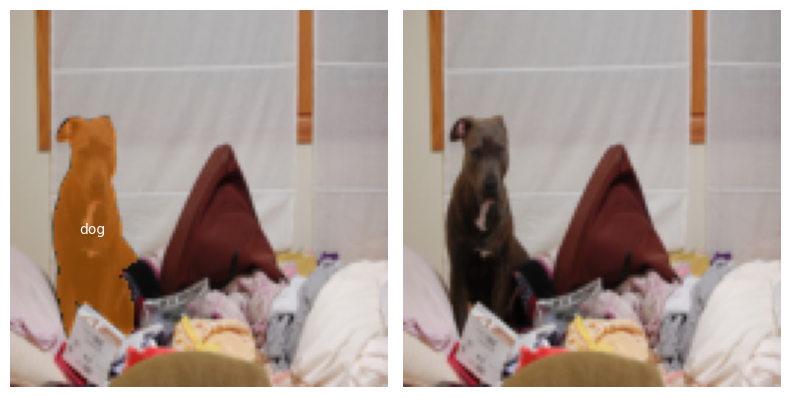

TRAIN EPOCH (/batches):   0%|          | 0/2 [00:00<?, ?it/s]

VALIDATION (/batches):   0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION (/batches):   0%|          | 0/1 [00:00<?, ?it/s]

compute_iou_matrix : pas de predictions ou pas de targets
[epoch 2/2]: train loss = 1.901073396205902 | val loss = 1.7368260787334293 | iou = 0.0


BATCHES:   0%|          | 0/1 [00:00<?, ?it/s]

No detections — skipping LVIS evaluation.


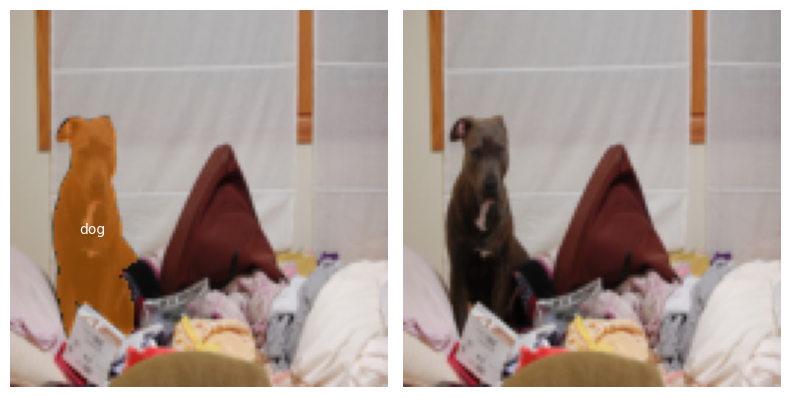

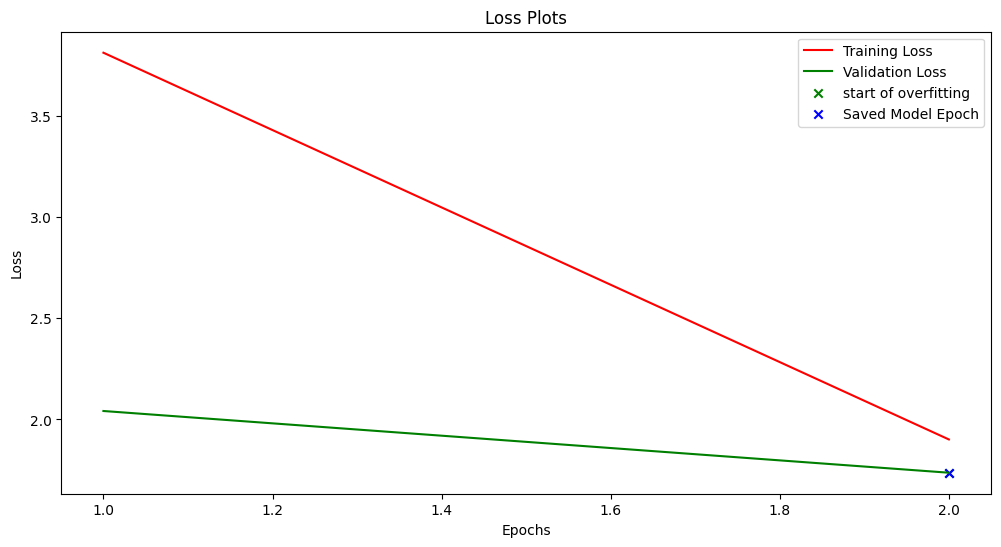

<Figure size 640x480 with 0 Axes>

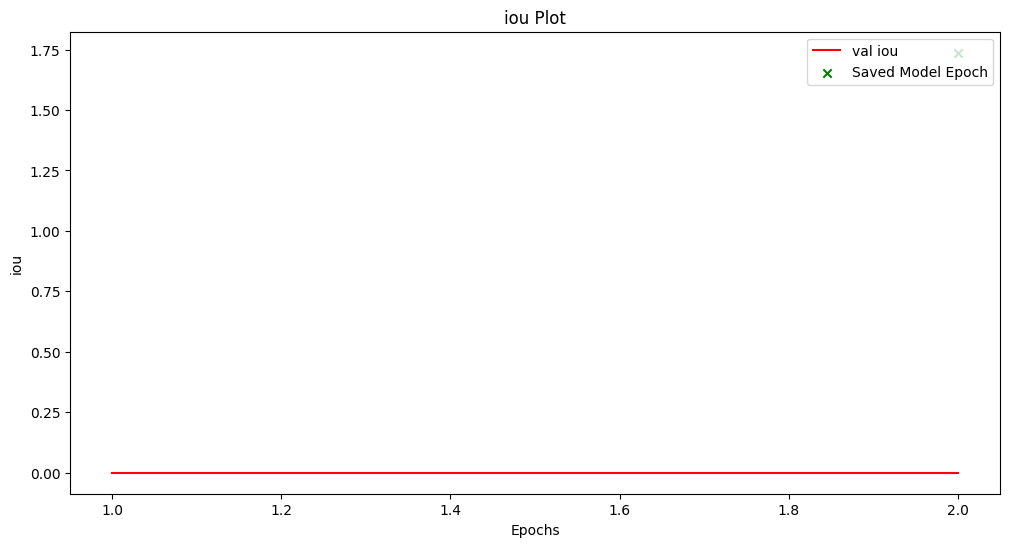

In [14]:
### Training Loop
train_losses, val_losses,val_iou, best_epoch, early_stop_epoch = train(model,
                                             optimizer, lr_scheduler,
                                             train_loader, val_loader,
                                             EPOCHS, PATIENCE,
                                             device, scaler, BATCH_PRINT_FREQ)
plot_losses(train_losses, val_losses, best_model_epoch=best_epoch,early_stop=early_stop_epoch, filepath="losses.jpg")
plot_iou(val_iou, early_stop=best_epoch)

#### Evaluation & Visualisation

In [15]:
### load best model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
best_model = get_model_instance_segmentation(num_classes)
best_model.load_state_dict(torch.load(SAVE_MODEL_PATH, map_location=device))
best_model.to(device)
print('')

cpu



In [16]:
### run full LVIS evaluation
run_lvis_eval(best_model, val_loader, lvis_gt_val, cat_ids, device, iou_type="segm")

BATCHES:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\CYTech Student\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


No detections — skipping LVIS evaluation.


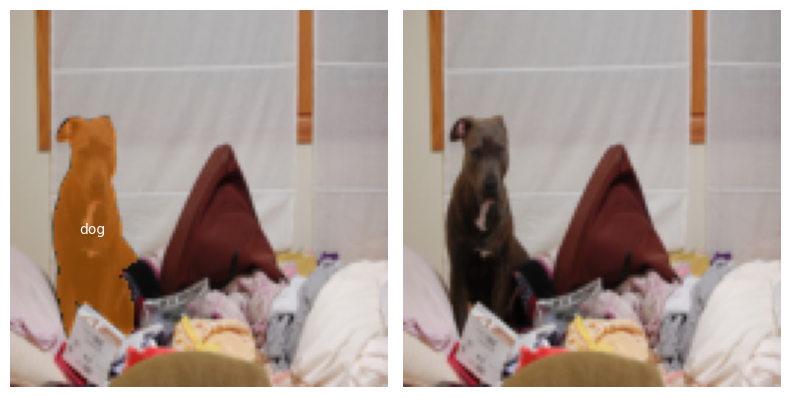

In [17]:
### visualization
IMAGES_TO_SHOW = 5
PRED_THRESH = 0.8

label_to_name = {k: lvis_gt_val.load_cats([v])[0]['name'] for k, v in
                 val_loader.dataset.dataset.label_to_cat_id.items()}

images, targets = next(iter(val_loader))
images = [img.to(device) for img in images]
best_model.eval()
with torch.no_grad():
    preds = best_model(images)
for i in range(min(IMAGES_TO_SHOW, len(images))):
    plot_images_with_anns(images[i], targets[i], preds[i], label_to_name, PRED_THRESH)

# --- tests ---

In [18]:
from lvis import LVISVis

predictions = get_predictions(model, val_loader, device)
if len(predictions) == 0:
    print("No detections — skipping LVIS evaluation.")
else:
    lvis_dt = LVISResults(lvis_gt_val, predictions)

lvis_vis = LVISVis(lvis_gt_val, lvis_dt, img_dir=COCO2017_VAL_PATH)

BATCHES:   0%|          | 0/1 [00:00<?, ?it/s]

No detections — skipping LVIS evaluation.


NameError: name 'lvis_dt' is not defined

In [ ]:
from lvis import LVIS, LVISVis

lvis_gt = LVIS(VAL_ANNOT_PATH)

lvis_vis = LVISVis(lvis_gt, img_dir=COCO2017_VAL_PATH)

lvis_vis.vis_img(285)

In [ ]:
# model training output
model = get_model_instance_segmentation(num_classes)
print("debug 1")
images, targets = next(iter(train_loader))
print("debug 2")
images = list(image for image in images)
print("debug 3")
targets = [{k: v for k, v in t.items()} for t in targets]
print("debug 4")
output = model(images, targets)  # Returns losses and detections
print("debug 5")
print(output)

In [ ]:
# model inference output
@torch.inference_mode()
def test(model):
    model.eval()
    print("debug 1")
    x = [torch.rand(3, 300, 400).to(device), torch.rand(3, 500, 400).to(device)]
    print("debug 2")
    predictions = model(x)  # Returns predictions
    print("debug 3")
    print(predictions[0])


test(model)

In [ ]:
import cv2

img = cv2.imread("../coco2017/train2017/000000055296.jpg")
if img is None:
    print("erreur imgage pas found")
cv2.imshow("test", img)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [ ]:
import json

with open("data/lvis_v1_val.json", "r") as f:
    data = json.load(f)

category_fields = list(data["categories"][0].keys())

print(category_fields)
